# 第五章 PDF 文件和图像处理

- [一、引言 ](#一、引言 )
- [二、文件和图像分析技术](#二、文件和图像分析技术)
  - [2.1文档布局检测](#2.1文档布局检测)
  - [2.2视觉_Transformers](#2.2视觉_Transformers)
  - [2.3优劣分析](#2.3优劣分析)
- [三、中文案例演示](#三、中文案例演示)
- [四、本章小结](#四、本章小结)

##### 

## 一、引言


像 PDF 和图像这一类文件，需要进行预处理才能和大模型交互。本章会涉及一些预处理的方法，包括“文档布局检测 （Document Layout Detection） ”和”视觉 Transformers（Vision Transformers）”,并学习如何使用这些工具完成预处理。对于非结构化的文件，如 PDF 和图像，**我们需要使用它们的视觉信息来完成解析,从中提取格式化的信息和文本。**

## 二、文件和图像的分析技术
### 2.1 **文档布局检测 （Document Layout Detection）**

文档布局检测使用目标检测模型在文档中绘制并标注边框，并从标注好的边框内提取文本信息。
**这个过程需要两步完成，第一步识别和分类文章中元素的边界框，第二步在这些边界框内提取文本。**
- **对于第一步**，首先会对文档的元素绘制边界框，例如叙述性文字、题目或项目符号。接着，需要提取边界框中的文本。**这里有两种情况**：
      1.文档本身不支持直接提取时，需要借助类似于“目标字符识别”或“ OCR ”等工具完成提取。
      2.文档支持直接提取时，使用边界框信息将边界框追溯回原始文档，并提取落在边界框内的文本内容即可。
    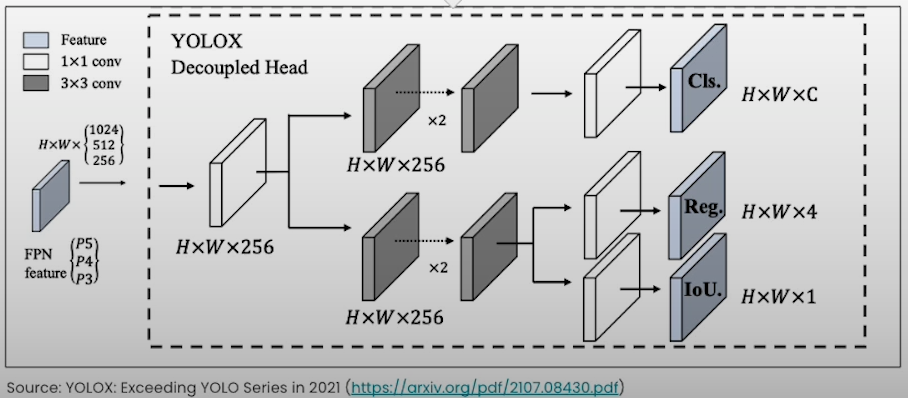（YOLO X model 是常被用作进行文档布局检测任务的模型，如果对它的结构感兴趣，可以查看原论文 https://arxiv.org/pdf/2107.08430.pdf。）
    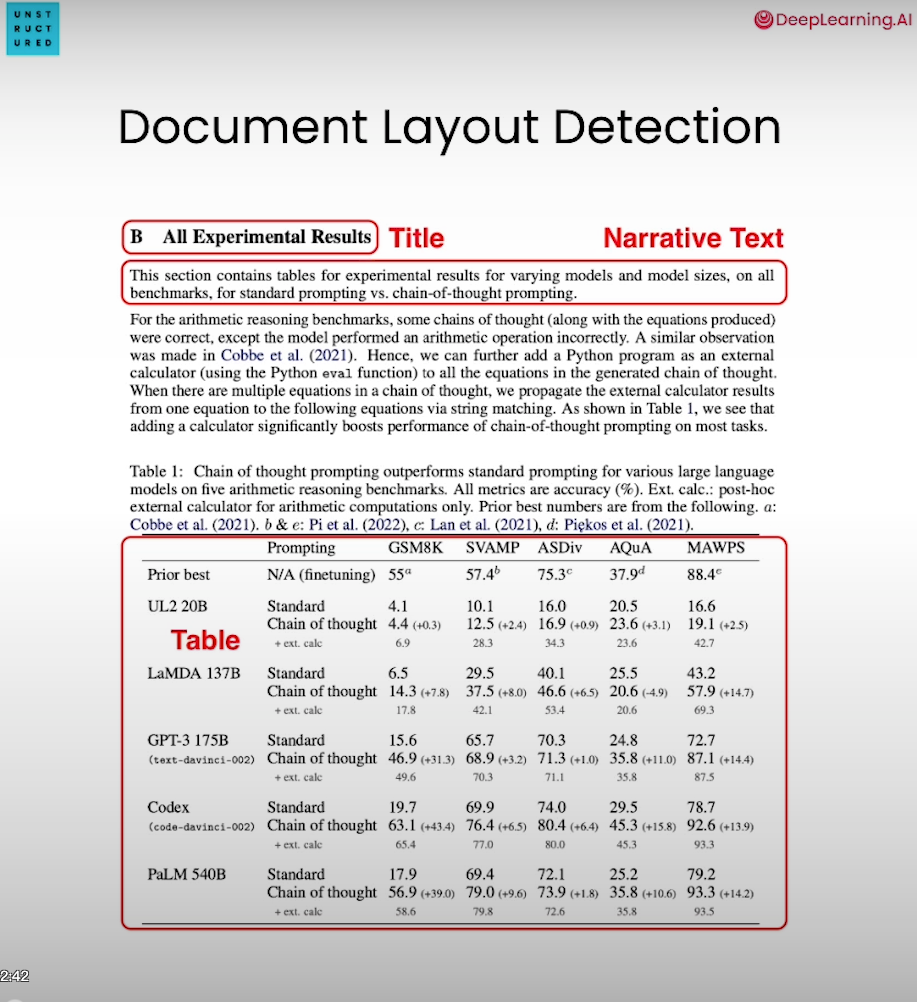（这是提取过程的示例）
- **对于第二步**，只需要识别到边界框就可以直接提取内容了。

### 2.2 **视觉 Transformers（Vision Transformers）**
视觉 Transformers（ViT） 完成这个任务只需要一步,并且不再需要 OCR 等工具。常见的结构就是 DONUT（Document Understanding Transformer）,可以通过编码器和解码器直接将输入的图像处理为输出的文本，并且可以训练这些模型来输出特定格式的文本，如 JSON 格式。
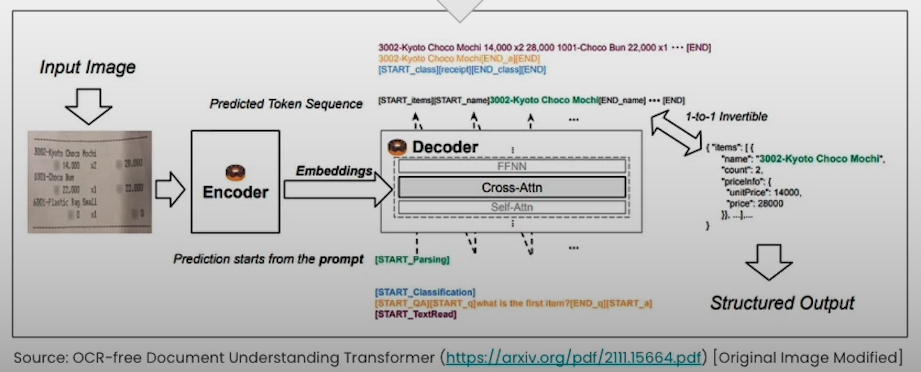（这是 DONUT 模型的结构示意图，如果对此感兴趣的话，可以进一步查看原论文 https://arxiv.org/pdf/2111.15664.pdf
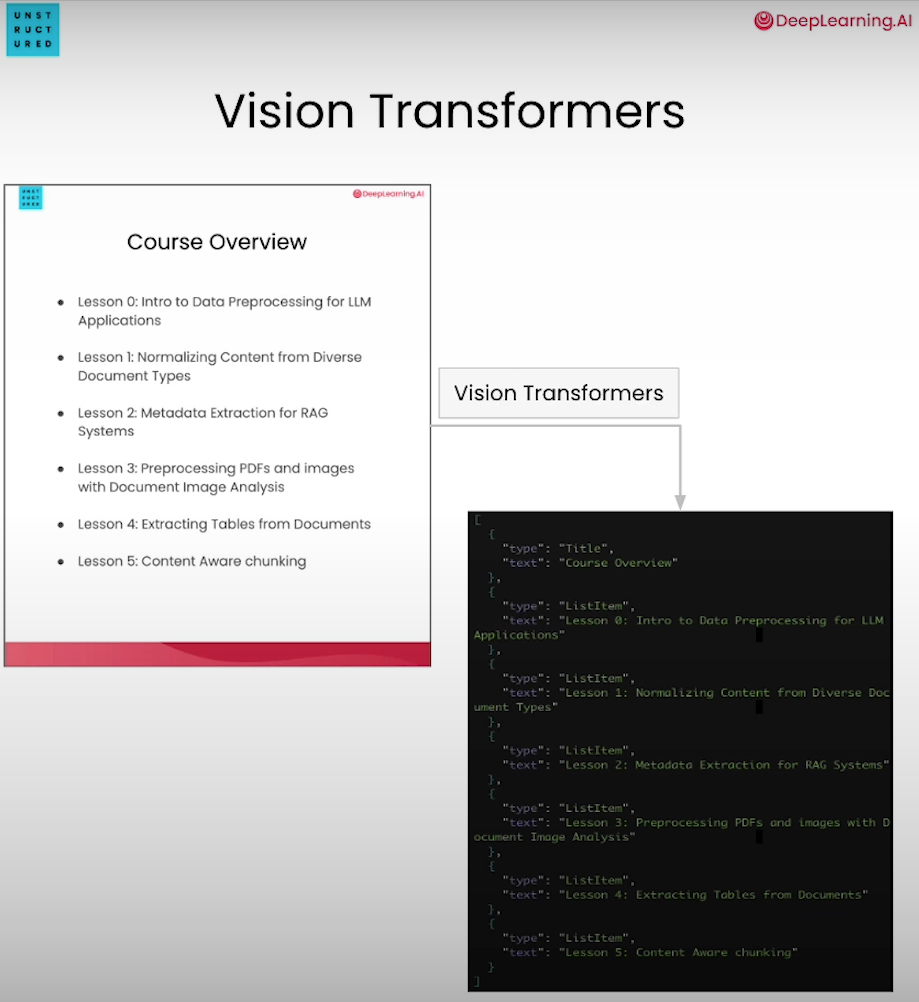 (这是提取过程的示例)

### 2.3 **优劣分析**
- 文档布局检测的优点是**可以提取到固定元素类型的合集并获得边界框的信息，方便回溯原文**，但是却需要两个模块（目标检测和 OCR），缺乏灵活性。
- 视觉 Transformers 更加灵活，**可以自定义需要提取的内容，并且适用于更多类型的无结构文档**。缺点在于，该方法需要使用到生成模型，容易引发幻觉或重复，并且需要较高的算力成本。



## 三、中文案例演示

In [1]:
# 忽略一些可能出现的警告
import warnings
warnings.filterwarnings('ignore')

In [2]:
# 导入需要的库，如果有没有安装完成的库，可以依据根目录下的requirements.txt文件进行安装和版本控制
from unstructured_client import UnstructuredClient
from unstructured_client.models import shared
from unstructured_client.models.errors import SDKError
from unstructured.partition.html import partition_html
from unstructured.partition.pdf import partition_pdf
from unstructured.staging.base import dict_to_elements

In [ ]:
# Utils模块可以在根目录找到
from Utils_Ch5 import Utils

utils = Utils()

DLAI_API_KEY = utils.get_dlai_api_key()
DLAI_API_URL = utils.get_dlai_url()

# 提供注册好的API_key和Server_url
s = UnstructuredClient(api_key_auth="your_api_key", server_url='your_server_url')

None


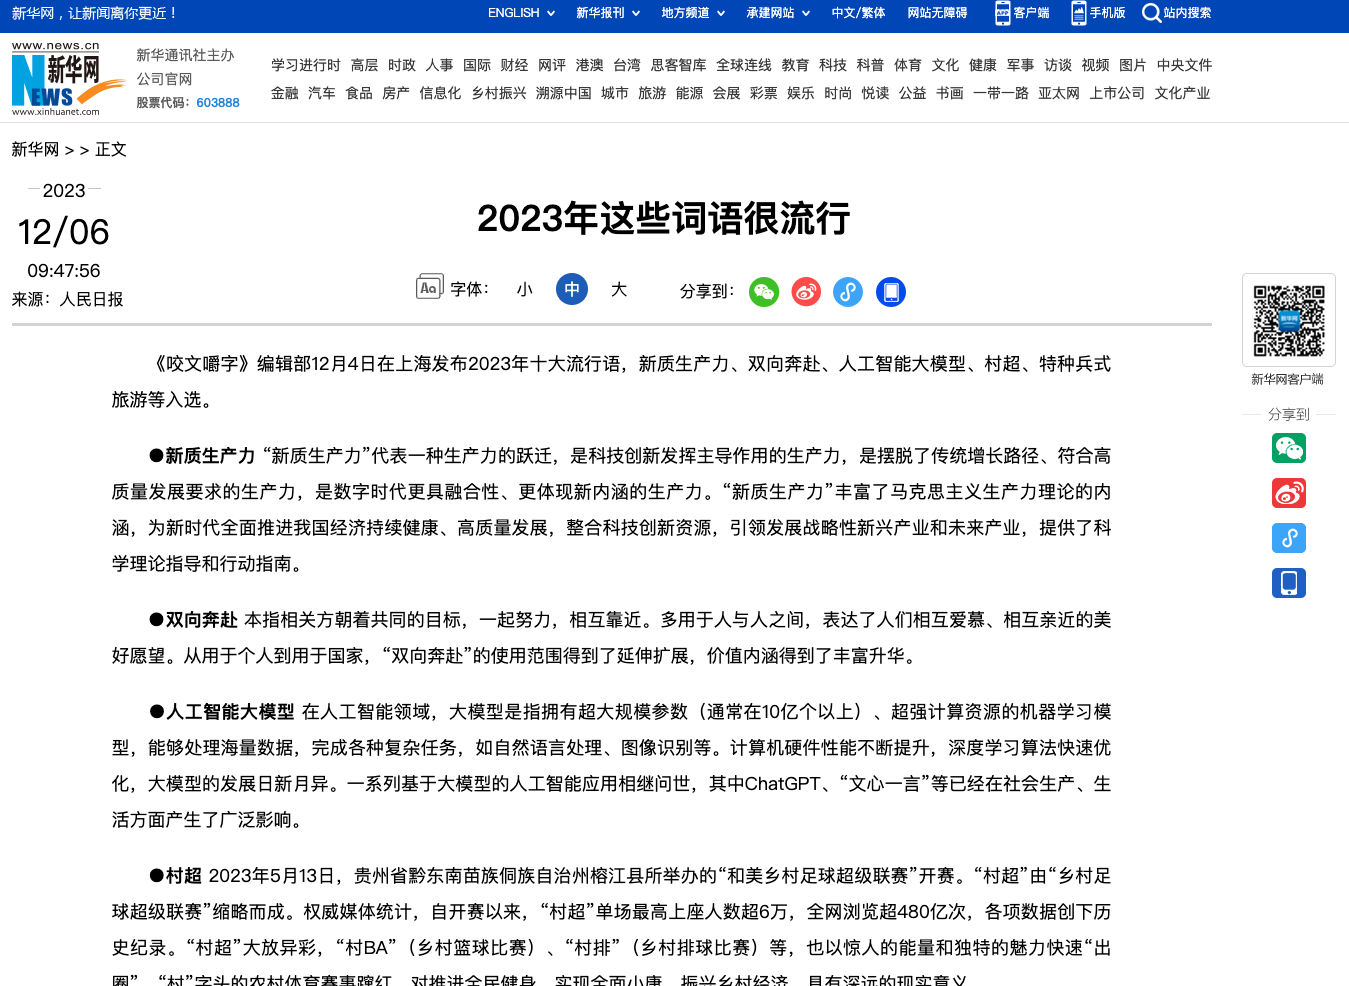

In [4]:
from IPython.display import Image
Image(filename="示例文件/2023十大流行词.png", height=600, width=600) 

我们使用不同的形式（html 和 pdf）表达同样的内容，来测试上述工具的效果

In [5]:
# 将内容以html的形式导入
filename = "示例文件/2023十大流行词.html"
html_elements = partition_html(filename=filename)

INFO: Reading document from string ...
INFO: Reading document ...


In [6]:
# 打印提取到的元素
for element in html_elements[:10]:
    print(f"{element.category.upper()}: {element.text}")

TITLE: 网站无障碍
TITLE: PC版本
TITLE: 首页
TITLE: 学习进行时
TITLE: 高层
TITLE: 时政
TITLE: 人事
TITLE: 国际
TITLE: 财经
TITLE: 网评


In [7]:
# 将内容以pdf的形式导入
filename = "示例文件/2023十大流行词.pdf"
pdf_elements = partition_pdf(filename=filename,strategy="fast")

INFO: PDF text extraction failed, skip text extraction...


In [8]:
# 打印提取到的元素
for element in pdf_elements[:10]:
    print(f"{element.category.upper()}: {element.text}")

In [9]:
# 使用yolox model来提取文本
with open(filename, "rb") as f:
    files=shared.Files(
        content=f.read(),
        file_name=filename,
    )
# 创建一个 PartitionParameters 对象，并赋值给变量 req
req = shared.PartitionParameters(
    files=files,
    strategy="hi_res", # 设置分区策略为 "hi_res"，表示高分辨率处理模式
    hi_res_model_name="yolox",
)

try:
    resp = s.general.partition(req)
    dld_elements = dict_to_elements(resp.elements)
except SDKError as e: # 捕获到 SDKError 异常
    print(e)

INFO: Partitioning without split.
INFO: Successfully partitioned the document.


In [10]:
for element in dld_elements[:10]:
    print(f"{element.category.upper()}: {element.text}")

HEADER: 2024/6/17 16:07
IMAGE: www.news.cn e f wvaw.xinhuanet.com
UNCATEGORIZEDTEXT: 新华⽹ > > 正⽂
NARRATIVETEXT: 2023
UNCATEGORIZEDTEXT: 12/06 09:47:56
NARRATIVETEXT: 来源：⼈⺠⽇报
HEADER: 新华通讯社主办 公司官⽹ 股票代码：603888
HEADER: 2023年这些词语很流⾏- 新华⽹内蒙古频道
HEADER: 新华报刊 地⽅频道 承建⽹站 中⽂/繁体 ⽹站⽆障碍 客户端
TITLE: ENGLISH


In [11]:
# 接下来比较一下提取效果
import collections

In [ ]:
# 统计从网页中提取到的内容长度
len(html_elements)

253

In [13]:
# 统计从网页中提取到的内容标签
html_categories = [el.category for el in html_elements]
collections.Counter(html_categories).most_common()

[('Title', 162),
 ('ListItem', 83),
 ('UncategorizedText', 7),
 ('NarrativeText', 1)]

In [14]:
# 统计从文件中提取到的内容长度
len(dld_elements)

38

In [15]:
# 统计从文件中提取到的内容标签
dld_categories = [el.category for el in dld_elements]
collections.Counter(dld_categories).most_common()

[('NarrativeText', 25),
 ('Header', 8),
 ('UncategorizedText', 2),
 ('Title', 2),
 ('Image', 1)]

In [16]:
# 在web 界面中创建一个文件上传的小部件
# 并将其放置在一个行布局中，以便于用户能够在界面上进行文件上传操作
import panel as pn
from Utils_Ch5 import UploadFile
pn.extension()

upld_widget = UploadFile()
pn.Row(upld_widget.widget_file_upload)

Row
    [0] FileInput(accept='.pdf,.ppt,.png,.html')

In [17]:
!ls ./示例文件

2023十大流行词.html       2023十大流行词_files      el_nino.png
2023十大流行词.pdf        el_nino.html
2023十大流行词.png        el_nino.pdf


## 四、本章小结

针对非结构化的 PDF 文件或图像，需要利用其视觉信息来进行解析。本章提供了两种方法，分别是“文档布局检测（Document Layout Detection）”和“视觉 Transformers（Vision Transformers）"，两种方式各有优劣，按需选择即可。